## **Klasifikasi Audio Huruf Vokal menggunakan CNN 🎙️🧠**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Memastikan bahwa Google Colab dapat mengakses Google Drive

In [ ]:
#Import library
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch

## Menyiapkan Dataset untuk Training Model
Dataset yang digunakan didapatkan menggunakan rekaman suara menirukan suara hewan moo, woof, meow, tweet, mbee sebanyak 15x setiap vokalnya. Data rekaman suara disimpan di google drive.

In [ ]:
#Parameters
SAMPLE_RATE = 16000
DURATION = 2  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION
VOWELS = ['moo', 'meow', 'woof', 'mbee', 'tweet']

# Ganti DATA_DIR untuk menunjuk ke Google Drive Anda
DATA_DIR = '/content/drive/My Drive/speech_classification/data'


## Pre-processing Dataset dan Ekstraksi Fitur 🔍
Tujuan tahap ini ialah untuk menyiapkan data mentah menjadi fitur siap model. Pre-processing meliputi proses:
- **VAD** (Voice Activity Detection) untuk membuang silent segments  
- **Padding/cropping** agar durasi konsisten  
- **Normalisasi amplitudo**  
- Ekstraksi **MFCC** (40 koefisien), distandarisasi
- Membuat Custom Dataset dan Menyimpan pasangan (MFCC, label)  
- Memisahkan dataset menjadi train (10 data) dan test (5 data)
- Definisi Arsitektur CNN

In [ ]:
# Preprocessing Audio Preprocessing dengan VAD dan Feature Extraction
def preprocess_audio(file_path, sr=SAMPLE_RATE, num_samples=NUM_SAMPLES, top_db=20):
    y, _ = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size:
        y = np.concatenate([y[start:end] for start, end in intervals])
    if len(y) < num_samples:
        y = np.pad(y, (0, num_samples - len(y)))
    else:
        y = y[:num_samples]
    max_amp = np.max(np.abs(y)) + 1e-6
    y = y / max_amp
    return y


def extract_features(file_path):
    y = preprocess_audio(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    return mfcc.astype(np.float32)

# Custom Dataset
def gather_files():
    all_files = []
    for label_idx, vowel in enumerate(VOWELS):
        files = sorted(os.listdir(os.path.join(DATA_DIR, vowel)))
        full = [os.path.join(DATA_DIR, vowel, f) for f in files]
        all_files += [(f, label_idx) for f in full]
    return all_files

class VowelDataset(Dataset):
    def __init__(self, file_label_pairs):
        self.data = []
        for f, label in file_label_pairs:
            feats = extract_features(f)
            self.data.append((feats[np.newaxis, ...], label))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# Menyiapkan DataLoaders
files = gather_files()
train_list, test_list = [], []
for v_idx, vowel in enumerate(VOWELS):
    fl = [p for p in files if p[1] == v_idx]
    train_list += fl[:10]
    test_list += fl[10:]

train_ds = VowelDataset(train_list)
test_ds = VowelDataset(test_list)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# Definisikan CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # compute output size
        dummy = torch.zeros(1,1,40, NUM_SAMPLES//512+1)
        out = self.conv(dummy)
        self.flatten_dim = out.numel()//out.shape[0]
        self.fc = nn.Linear(self.flatten_dim, len(VOWELS))
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

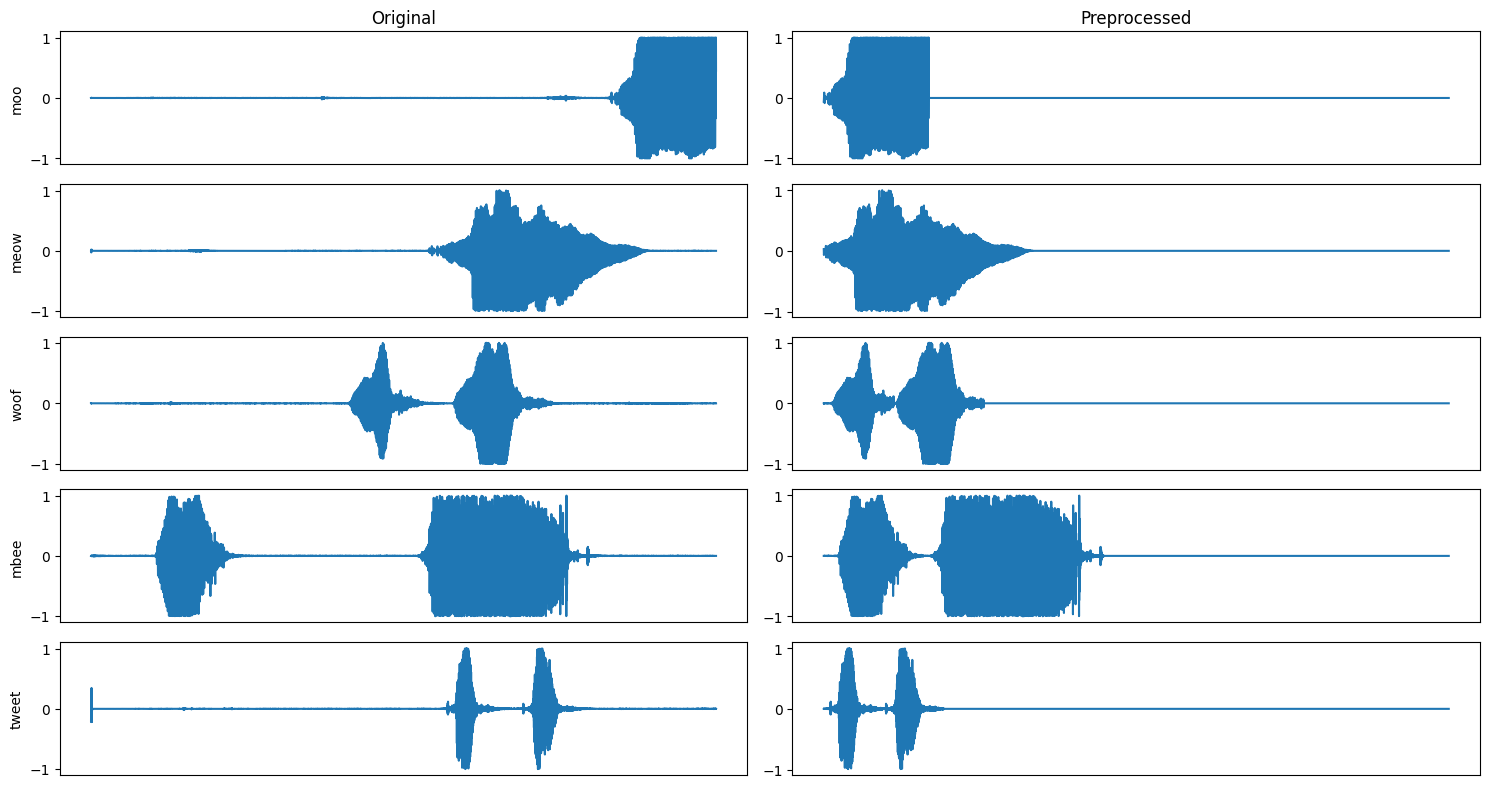

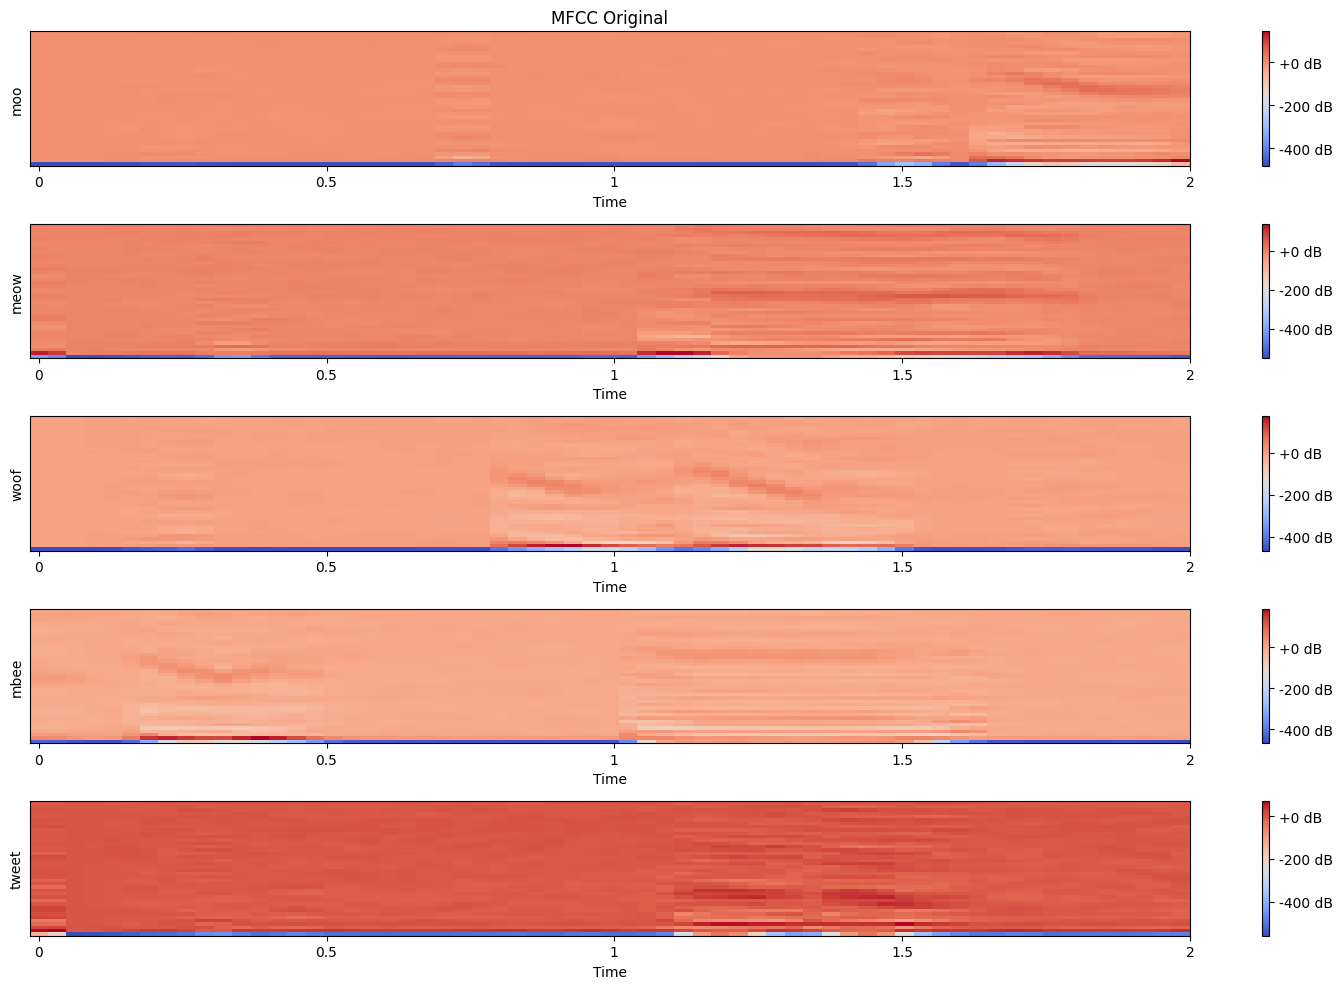

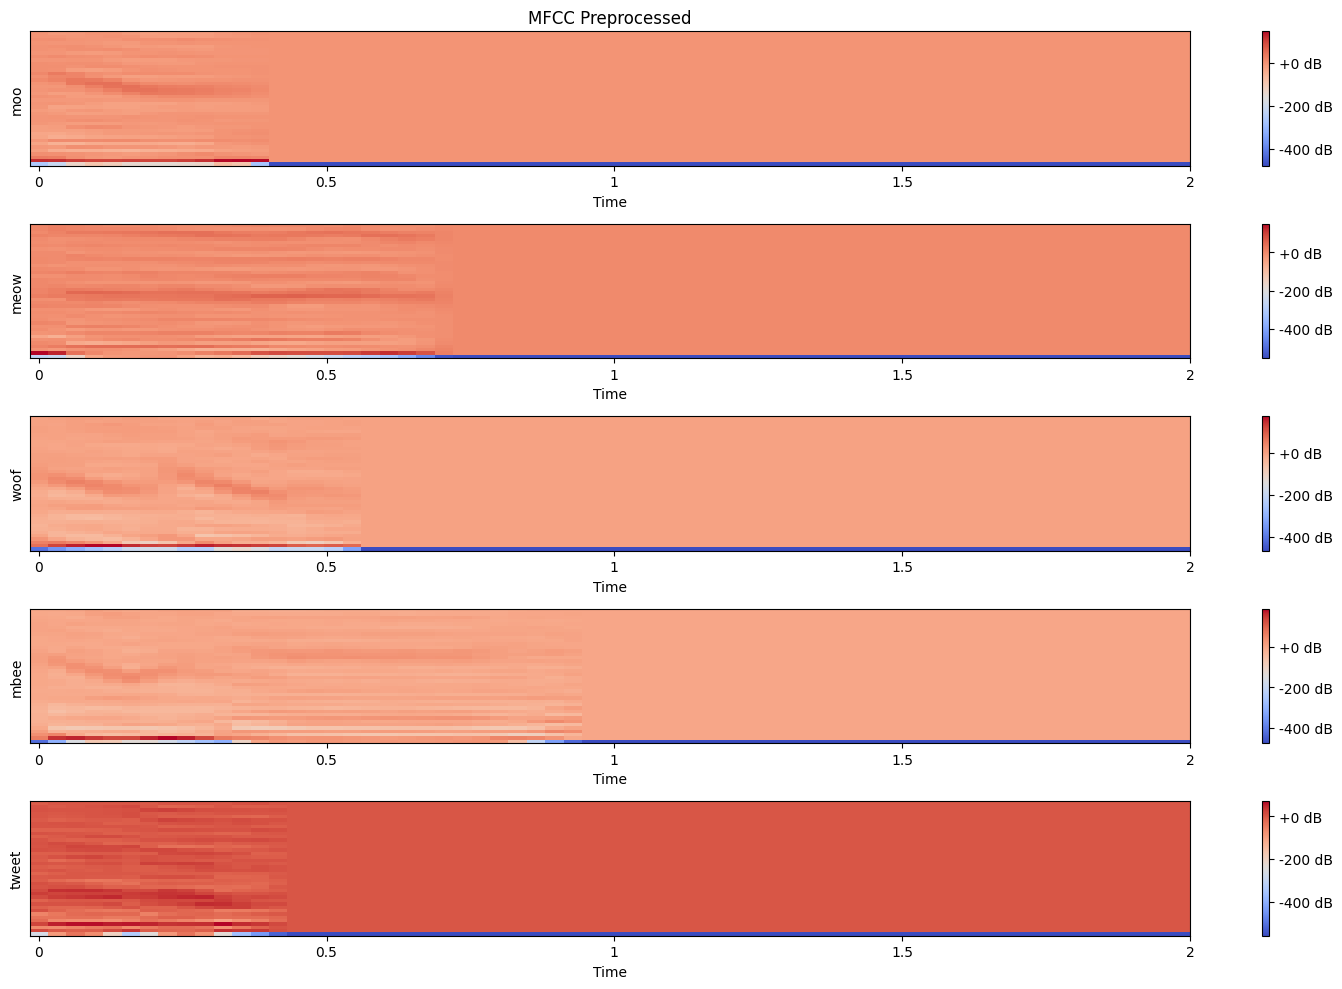

In [ ]:
# Perbandingan Bentuk Gelombang dan MFCC tiap Vokal
files_by_vowel = {v: sorted(os.listdir(os.path.join(DATA_DIR, v))) for v in VOWELS}
sample_idx = 0

plt.figure(figsize=(15, 8))
for i, v in enumerate(VOWELS):
    fpath = os.path.join(DATA_DIR, v, files_by_vowel[v][sample_idx])
    y_o, _ = librosa.load(fpath, sr=SAMPLE_RATE)
    y_p = preprocess_audio(fpath)
    plt.subplot(len(VOWELS), 2, 2*i+1)
    plt.plot(y_o)
    if i == 0: plt.title('Original')
    plt.ylabel(v)
    plt.xticks([])
    plt.subplot(len(VOWELS), 2, 2*i+2)
    plt.plot(y_p)
    if i == 0: plt.title('Preprocessed')
    plt.xticks([])
plt.tight_layout()
plt.show()


for mode, y_func in [('Original', lambda f: librosa.load(f, sr=SAMPLE_RATE)[0][:NUM_SAMPLES]),
                     ('Preprocessed', lambda f: preprocess_audio(f))]:
    plt.figure(figsize=(15, 10))
    for i, v in enumerate(VOWELS):
        fpath = os.path.join(DATA_DIR, v, files_by_vowel[v][sample_idx])
        y = y_func(fpath)
        mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
        plt.subplot(len(VOWELS), 1, i+1)
        librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel(v)
        if i == 0: plt.title(f'MFCC {mode}')
        else: plt.title('')
    plt.tight_layout()
    plt.show()


### Kesimpulan Pre-Processing Data
Visualisasi bentuk gelombang menunjukkan bahwa tahap pre-processing berhasil membersihkan sinyal audio dari segmen hening dan menstandardisasi durasi serta amplitudo, dibandingkan dengan sinyal original. Plot MFCC, yang merupakan fitur penting untuk klasifikasi suara, merefleksikan perbaikan ini. MFCC dari data yang telah diproses terlihat lebih konsisten dan terfokus, menciptakan "sidik jari" akustik yang jelas untuk setiap vokal ('moo', 'meow', 'woof', 'mbee', 'tweet'). Hal ini memvalidasi efektivitas pre-processing dalam menyiapkan data audio berkualitas tinggi untuk pelatihan model CNN, sesuai dengan kesimpulan bahwa data sudah bersih dan ternormalisasi.

## **TRAINING MODEL** 📈

Using device: cpu
Epoch 100/100, Loss: 0.0005, Train Acc: 100.00%, Test Acc: 96.00%


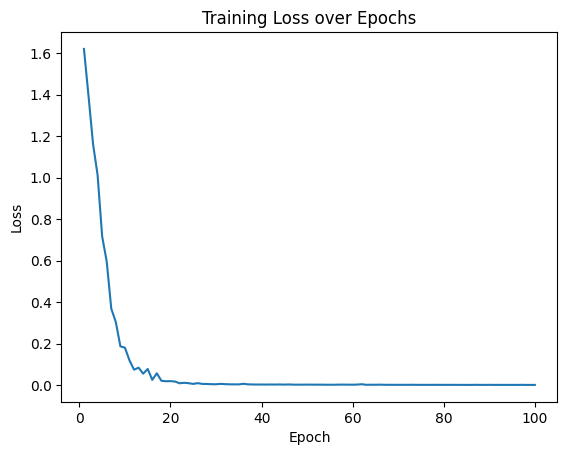

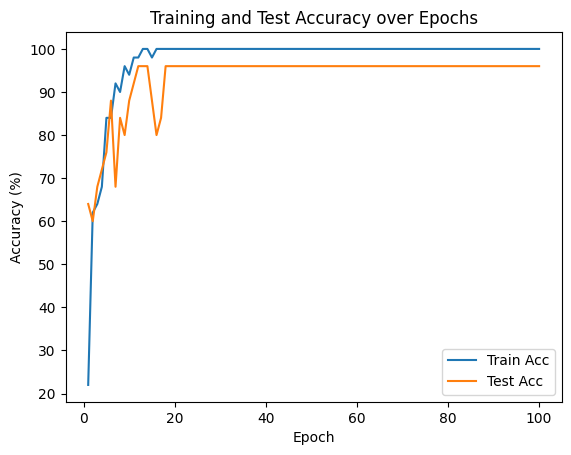

In [ ]:
# Training Model
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
# Initialize lists to store metrics
train_losses, train_accs, test_accs = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)
    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train

    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            preds_t = out_t.argmax(dim=1)
            correct_test += (preds_t == y_t).sum().item()
            total_test += y_t.size(0)
    test_acc = 100.0 * correct_test / total_test

    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Progress
    sys.stdout.write(
        f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%"
    )
    sys.stdout.flush()
print()

epochs_range = range(1, epochs + 1)
# Plot loss
plt.figure()
plt.plot(epochs_range, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()


Dari plot Training Loss over Epochs, terlihat bahwa training loss menurun secara konsisten seiring bertambahnya jumlah epoch. Ini menunjukkan bahwa model berhasil mempelajari pola dari data training dan error pada data training semakin kecil seiring waktu.

Dari plot Training and Test Accuracy over Epochs, terlihat bahwa training accuracy mencapai 100.00% pada akhir training. Sementara itu, test accuracy mencapai 96.00%. Adanya perbedaan antara training accuracy yang sempurna dan test accuracy yang sedikit lebih rendah (meskipun masih sangat tinggi) bisa mengindikasikan adanya sedikit overfitting pada data training, di mana model terlalu spesifik mempelajari data training namun sedikit kurang general pada data yang belum pernah dilihat (data test).

In [ ]:
# Evaluasi Kinerja Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}% \n")

# Classification Report
from sklearn.metrics import classification_report
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        _, pred = torch.max(out, 1)
        all_preds += pred.cpu().tolist()
        all_labels += y.tolist()
print(classification_report(all_labels, all_preds, target_names=VOWELS))

Test Accuracy: 96.00% 

              precision    recall  f1-score   support

         moo       1.00      1.00      1.00         5
        meow       1.00      1.00      1.00         5
        woof       1.00      0.80      0.89         5
        mbee       1.00      1.00      1.00         5
       tweet       0.83      1.00      0.91         5

    accuracy                           0.96        25
   macro avg       0.97      0.96      0.96        25
weighted avg       0.97      0.96      0.96        25



Hasil Classification Report lebih detail menunjukkan kinerja model pada setiap kelas (vokal). Model menunjukkan performa sempurna (precision, recall, f1-score 1.00) untuk vokal 'moo', 'meow', dan 'mbee' pada data test. Untuk vokal 'woof', recall sedikit lebih rendah (0.80), yang berarti ada satu sampel 'woof' di data test yang tidak berhasil diprediksi dengan benar. Untuk vokal 'tweet', precision sedikit lebih rendah (0.83), meskipun recall-nya sempurna (1.00). Secara keseluruhan, macro avg dan weighted avg f1-score yang mencapai 0.96 menunjukkan kinerja model yang sangat baik pada dataset test ini.

Kesimpulannya, model CNN yang dilatih menunjukkan performa yang sangat kuat dalam mengklasifikasikan suara vokal yang diberikan, dengan akurasi tinggi pada data test. Namun, penting untuk mempertimbangkan ukuran dataset yang kecil dan variasi yang terbatas sebagai faktor dalam interpretasi hasil ini. Pengujian lebih lanjut dengan dataset yang lebih besar dan lebih bervariatif akan memberikan gambaran yang lebih akurat tentang kemampuan generalisasi model.

In [ ]:
# Save Model
torch.save(model.state_dict(), 'animal_cnn.pth')
print("Model disimpan!")

Model disimpan!


#### **UJI COBA KLASIFIKASI SUARA VOKAL DENGAN MODEL YANG TELAH DIBUAT** 🚀

In [ ]:
#Test Prediction via file di Google Drive dengan menampilkan confidence tiap label
import torch.nn.functional as F
import os # Import os module

def predict_from_file(file_path, model, device):

    # Pastikan file_path ada sebelum diproses
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return

    feats = extract_features(file_path)
    x = torch.tensor(feats[np.newaxis, np.newaxis, ...]).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)
        probs = F.softmax(out, dim=1)[0]

    print(f"\n--- Hasil Prediksi untuk {os.path.basename(file_path)} ---")
    # tampilkan persentase untuk tiap vowel
    for idx, vowel in enumerate(VOWELS):
        print(f"{vowel}: {probs[idx].item()*100:.2f}%")

    # prediksi tertinggi
    pred_idx = probs.argmax().item()
    print(f"Vokal Yang Diprediksi: {VOWELS[pred_idx]}")

# Sesuaikan dengan path folder test
test_data_dir = '/content/drive/My Drive/speech_classification/test'

# Load model dan set device sekali di luar loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
model.load_state_dict(torch.load('./animal_cnn.pth', map_location=device))
model.eval() # Pastikan model dalam mode evaluasi

# Iterasi semua file di dalam folder 'test'
if os.path.exists(test_data_dir):
    for filename in os.listdir(test_data_dir):
        if filename.endswith('.wav'):
            full_file_path = os.path.join(test_data_dir, filename)
            predict_from_file(full_file_path, model, device)
else:
    print(f"Error: Folder test data tidak ditemukan di {test_data_dir}")


--- Hasil Prediksi untuk bird_twit.wav ---
moo: 0.00%
meow: 0.00%
woof: 0.00%
mbee: 0.00%
tweet: 100.00%
Vokal Yang Diprediksi: tweet

--- Hasil Prediksi untuk dog_woof.wav ---
moo: 0.00%
meow: 0.01%
woof: 99.99%
mbee: 0.00%
tweet: 0.00%
Vokal Yang Diprediksi: woof

--- Hasil Prediksi untuk cow_moo.wav ---
moo: 99.87%
meow: 0.00%
woof: 0.13%
mbee: 0.00%
tweet: 0.00%
Vokal Yang Diprediksi: moo

--- Hasil Prediksi untuk cat_meow.wav ---
moo: 0.00%
meow: 100.00%
woof: 0.00%
mbee: 0.00%
tweet: 0.00%
Vokal Yang Diprediksi: meow

--- Hasil Prediksi untuk goat_mbee.wav ---
moo: 3.52%
meow: 0.68%
woof: 10.80%
mbee: 67.52%
tweet: 17.48%
Vokal Yang Diprediksi: mbee


model diuji menggunakan file audio dari folder /content/drive/My Drive/speech_classification/test. Hasil prediksi untuk setiap file audio ditampilkan bersama dengan tingkat kepercayaan (confidence) untuk setiap label (vokal).

Dari hasil yang ditampilkan:

* bird_twit.wav: Model dengan yakin memprediksi vokal 'tweet' dengan kepercayaan 100.00%.
* dog_woof.wav: Model dengan sangat yakin memprediksi vokal 'woof' dengan kepercayaan 99.99%.
* cow_moo.wav: Model dengan sangat yakin memprediksi vokal 'moo' dengan kepercayaan 99.87%.
* cat_meow.wav: Model dengan yakin memprediksi vokal 'meow' dengan kepercayaan 100.00%.
* goat_mbee.wav: Model memprediksi vokal 'mbee' dengan kepercayaan tertinggi (67.52%), meskipun ada kepercayaan yang signifikan juga pada vokal lain seperti 'tweet' (17.48%) dan 'woof' (10.80%).

Secara keseluruhan, hasil uji coba ini menunjukkan bahwa model mampu mengklasifikasikan sebagian besar suara vokal dari file test dengan tingkat kepercayaan yang sangat tinggi, sesuai dengan prediksi yang benar. Hasil ini konsisten dengan akurasi test 96.00% yang dilaporkan sebelumnya. Kasus 'goat_mbee.wav' menunjukkan sedikit keraguan model dibandingkan dengan vokal lainnya, namun tetap berhasil memprediksi label yang benar dengan kepercayaan tertinggi.

Ini adalah hasil yang sangat positif, menunjukkan bahwa model yang dilatih cukup efektif dalam tugas klasifikasi ini pada dataset yang digunakan.